In [2]:
import wandb
import matplotlib.pyplot as plt
import pandas as pd

# RQ1 - Scaling Climateset

# # Data Downloading and Preparation

In [3]:
api = wandb.Api()
Treatment_6 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "6_models"})
Treatment_36 = api.runs(f"causalpaca/emulator", filters = {'group' : "Baseline", 'tags': "36_models"})
Treatments = [Treatment_6,Treatment_36]
Treatment_Names = ["Treatment_6","Treatment_36"]

for treatment in Treatments:
  for model in treatment:
    try:
        print(model.name," RUNTIME: ", model.summary["_wandb"].runtime/60/60, "hours")
    except:
        print("Run not finished yet")



07_unet_Baseline_UNet_adam_2bs_0.0002lr_1e-06wd_3423seed_18h23m_on_Apr_16_0hhpzbk0  RUNTIME:  1.3377777777777777 hours
07_convlstm_Baseline_CNNLSTM_ClimateBench_adam_2bs_0.0002lr_1e-06wd_3423seed_18h11m_on_Apr_16_mreoar33  RUNTIME:  0.36138888888888887 hours
07_climax_frozen_Baseline_ClimaX_adamw_2bs_0.0005lr_1e-05wd_3423seed_18h05m_on_Apr_16_auacfjc3  RUNTIME:  2.7816666666666667 hours
07_climax_Baseline_ClimaX_adamw_2bs_0.0005lr_1e-05wd_3423seed_17h59m_on_Apr_16_vrx8xw10  RUNTIME:  3.915 hours
07_unet_Baseline_UNet_adam_2bs_0.0002lr_1e-06wd_3423seed_18h47m_on_Apr_16_h05nwwf1  RUNTIME:  8.540555555555555 hours
07_convlstm_Baseline_CNNLSTM_ClimateBench_adam_2bs_0.0002lr_1e-06wd_3423seed_18h38m_on_Apr_16_18v47a3i  RUNTIME:  2.2219444444444445 hours
07_climax_frozen_Baseline_ClimaX_adamw_2bs_0.0005lr_1e-05wd_3423seed_18h29m_on_Apr_16_0n6gjgdq  RUNTIME:  15.944444444444445 hours
07_climax_Baseline_ClimaX_adamw_2bs_0.0005lr_1e-05wd_3423seed_18h05m_on_Apr_16_x8e30hg0  RUNTIME:  20.947499999

In [4]:
def extract_parts_from_name(name):
    """
    Extracts parts from a given name.
    """
    parts = name.split('_')
    new_name = parts[1]
    if(parts[2]=="frozen"):
      new_name = new_name +"_"+ parts[2]
    print(new_name)
    return new_name

def filter_system_metrics(system_metrics, filter_criteria):
    """
    Filters system metrics based on specified criteria.
    """
    filtered_columns = [metric[0] for metric in filter_criteria]

    return system_metrics[filtered_columns]


data = []
for index, treatment in enumerate(Treatments):

  for model in treatment:
      # Fetching metrics for the specified run
      name = extract_parts_from_name(model.name)

      # Retrieving system metrics history
      system_metrics = model.history(stream="systemMetrics")
      filter_criteria = [
          ['system.cpu'],
          ['system.gpu.process.0.gpu'],
          ['system.proc.memory.rssMB'],
      ]
      # Filtering system metrics based on the specified criteria
      system_metrics_filtered = filter_system_metrics(system_metrics, filter_criteria)

      defaults = model.history()

      # Scanning history for default metrics
      default_metrics = model.scan_history()
      default_metrics_df = pd.DataFrame(default_metrics)
      still_running = False

      try:
        # Extract the required columns
        val_rmse = default_metrics_df['val/rmse'].ffill()
        val_rmse = val_rmse.bfill().tolist()
        emissions = default_metrics_df['emissions'].dropna().tolist()[0]
        steps = default_metrics_df['_step'].tolist()
      except:
        still_running = True

      if(still_running):
        continue

      # Creating DataFrame for the filtered default metrics and steps
      #val_rmse_df = pd.DataFrame({'val/rmse': val_rmse}).fillna(method='ffill')

      # Extracting runtime values from system metrics
      runtime_values = system_metrics['_runtime']

      runtime_hours = model.summary["_wandb"].runtime / 60 / 60
      # Create a new DataFrame for the current row
      data.append({
        "treatment": Treatment_Names[index],
        "name": name,
        "CPU": system_metrics_filtered['system.cpu'].dropna().to_list(),
        "GPU": system_metrics_filtered['system.gpu.process.0.gpu'].dropna().to_list(),
        "RSS-Memory in GB": system_metrics_filtered['system.proc.memory.rssMB'].dropna().to_list(),
        "RMSE": min(val_rmse),
        "Steps": steps,
        "runtime_hours": runtime_hours,
        "Co2": emissions,
      })
# Convert the list of dictionaries to a DataFrame


unet
convlstm
climax_frozen
climax
unet
convlstm
climax_frozen
climax


# Data Exploration

In [5]:
import numpy as np
import pandas as pd
import copy

# Define a function that computes the mean of a list
def mean_of_list(lst):
    return np.mean(lst)

# Define a function that computes the median of a list
def median_of_list(lst):
    return np.median(lst)

# Define a function that computes the standard deviation of a list
def std_of_list(lst):
    return np.std(lst)

# Create a new list of dictionaries
overViewTable_data = []

overviewData = copy.deepcopy(data)
# Iterate over the data list
for item in overviewData:
    # Create a new dictionary to store the mean, median, and standard deviation values
    new_item = {}
    # Compute the mean, median, and standard deviation for each list in each dictionary
    for col in ["CPU", "GPU", "RSS-Memory in GB"]:
        if col in item and isinstance(item[col], list):
            if col == "RSS-Memory in GB":
                  #for making RSS into GB
                  item[col] = [i / 1000 for i in item[col]]
            new_item[col + '_Mean'] = mean_of_list(item[col])
            new_item[col + '_Median'] = median_of_list(item[col])
            new_item[col + '_STD'] = std_of_list(item[col])
    # Add the values for "name", "treatment", "Co2", and "runtime_hours" to the new dictionary
    for col in ["name", "treatment", "Co2", "runtime_hours","RMSE"]:
        if col in item:
            new_item[col] = item[col]
    # Add the new dictionary to the new_data list
    overViewTable_data.append(new_item)

# Create a DataFrame from the new_data list
df = pd.DataFrame(overViewTable_data)
# Sort the DataFrame by 'name'
df = df.sort_values('name')

# Define the new order of the columns
new_order = ['name', 'treatment'] + [col for col in df.columns if col not in ['name', 'treatment']]

# Reorder the columns
df = df.reindex(columns=new_order)
# Print the DataFrame
# Round the DataFrame and convert to string
df = df.round(4).astype(str)

# Remove trailing zeros
df = df.replace('\.0+$', '', regex=True)

# Convert the DataFrame to a LaTeX table
latex_table = df.to_latex(index=False)

# Print the LaTeX table
print(latex_table)

\begin{tabular}{llllllllllllll}
\toprule
name & treatment & CPU_Mean & CPU_Median & CPU_STD & GPU_Mean & GPU_Median & GPU_STD & RSS-Memory in GB_Mean & RSS-Memory in GB_Median & RSS-Memory in GB_STD & Co2 & runtime_hours & RMSE \\
\midrule
climax & Treatment_6 & 1.9525 & 2.08 & 0.2161 & 56.4778 & 74.9 & 34.8744 & 13.6631 & 8.1911 & 8.1258 & 0.0026 & 3.915 & 1.0554 \\
climax & Treatment_36 & 1.9886 & 2.07 & 0.2664 & 63.1362 & 85.73 & 37.0446 & 44.5292 & 27.0602 & 34.3186 & 0.016 & 20.9475 & 0.7917 \\
climax_frozen & Treatment_6 & 2.0774 & 2.13 & 0.3233 & 48.4162 & 51.73 & 32.5024 & 14.9264 & 11.7339 & 7.8056 & 0.0018 & 2.7817 & 0.6453 \\
climax_frozen & Treatment_36 & 2.8265 & 2.955 & 0.2888 & 53.9751 & 83.87 & 39.1347 & 51.743 & 27.0653 & 37.8345 & 0.0098 & 15.9444 & 0.5159 \\
convlstm & Treatment_6 & 5.2174 & 5.55 & 1.0037 & 34.3712 & 37.67 & 10.1787 & 8.0684 & 8.0992 & 0.7335 & 0.0002 & 0.3614 & 0.559 \\
convlstm & Treatment_36 & 4.9799 & 4.965 & 0.5001 & 35.2224 & 36.4 & 6.3862 & 27

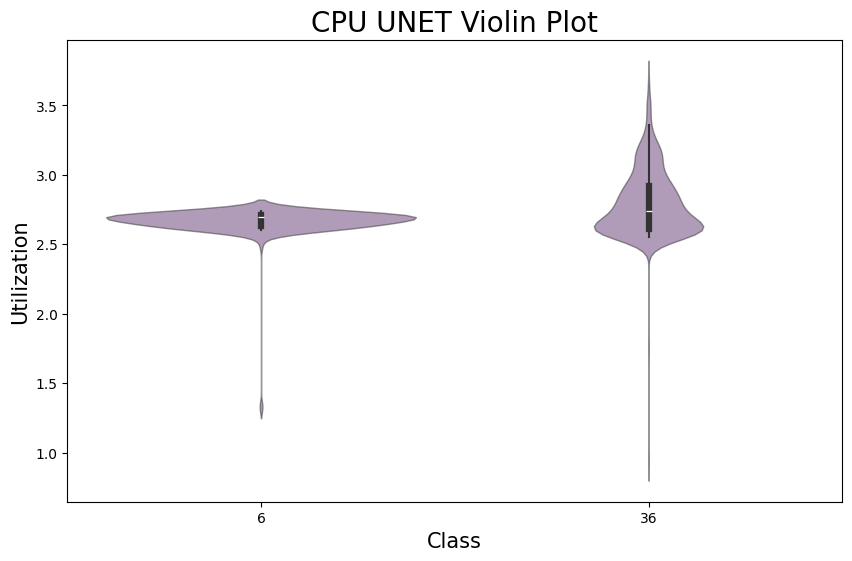

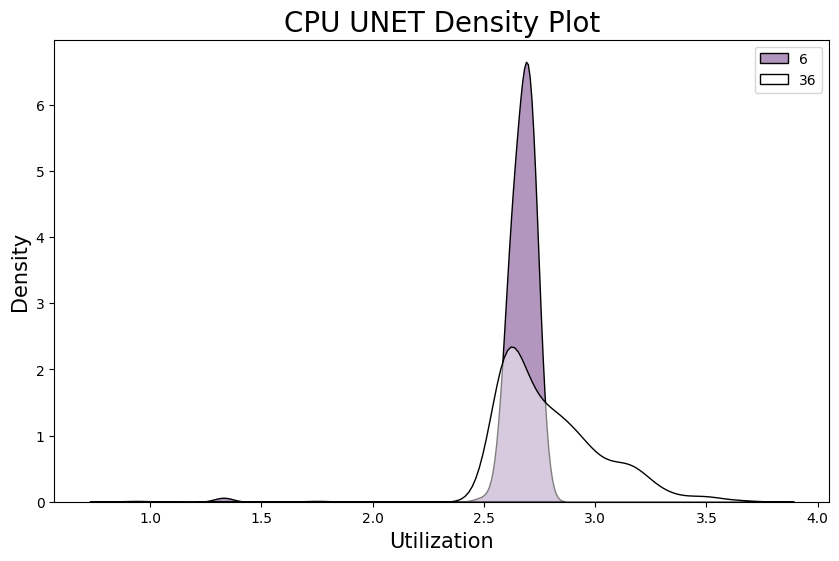

ValueError: The data contains non-finite values.

In [8]:
import seaborn as sns
import scipy.stats as stats
from seaborn_qqplot import pplot
from scipy.stats import norm


def create_violin_plot(data, x_labels,title,y):
    # Convert the list of lists into a DataFrame
    df = pd.DataFrame(data).T
    df.columns = x_labels

    # Melt the DataFrame to have columns and values
    df_melt = df.melt(var_name='class', value_name='value')

    # Create the violin plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(data=df_melt, x='class', y='value', inner="box", color="#662e7d", linewidth=1, alpha=.5)

    # Set the title and labels
    plt.title(title, fontsize=20)
    plt.xlabel('Class', fontsize=15)
    plt.ylabel(y, fontsize=15)

    # Show the plot
    plt.show()

def create_density_plot(data, x_labels, title, y):
    # Convert the list of lists into a DataFrame
    df = pd.DataFrame(data).T
    df.columns = x_labels

    # Melt the DataFrame to have columns and values
    df_melt = df.melt(var_name='class', value_name='value')

    # Create the density plot
    plt.figure(figsize=(10, 6))
    for i, label in enumerate(x_labels):
        color = "#662e7d" if i % 2 == 0 else "white"
        sns.kdeplot(data=df_melt[df_melt['class'] == label]['value'], fill=True, color=color, edgecolor="black", common_norm=False, alpha=.5, linewidth=1, label=label)

    # Set the title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(y, fontsize=15)
    plt.ylabel("Density", fontsize=15)

    # Add the legend
    plt.legend(loc='upper right')

    # Show the plot
    plt.show()

def create_qq_plot(data, x_labels, title):
    # Convert the list of lists into a DataFrame
    df = pd.DataFrame(data).T
    df.columns = x_labels

    # Create the Q-Q plot
    for i, label in enumerate(x_labels):
        color = "#662e7d" if i % 2 == 0 else "white"
        pplot(df, x=label, y=norm, kind='qq', height=4, aspect=2, display_kws={"identity":False, "fit":True, "reg":True, "ci":0.025})

    # Set the title
    plt.title(title, fontsize=20)

    # Show the plot
    plt.show()
    
# Create a DataFrame from the new_data list
PlotData =  copy.deepcopy(data)

Plots_df = pd.DataFrame(PlotData)
### UNET
unet_data_6 = Plots_df[(Plots_df['treatment'] == 'Treatment_6') & (Plots_df['name'] == 'unet')]
cpu_unet_6 = unet_data_6['CPU'].tolist()[0]
gpu_unet_6 = unet_data_6['GPU'].tolist()[0]
rss_unet_6 =  [i / 1000 for i in unet_data_6['RSS-Memory in GB'].tolist()[0]]
unet_data_36 = Plots_df[(Plots_df['treatment'] == 'Treatment_36') & (Plots_df['name'] == 'unet')]
cpu_unet_36 = unet_data_36['CPU'].tolist()[0]
gpu_unet_36 = unet_data_36['GPU'].tolist()[0]
rss_unet_36 = [i / 1000 for i in unet_data_36['RSS-Memory in GB'].tolist()[0]]
CPU = [cpu_unet_6,cpu_unet_36]
GPU = [gpu_unet_6,gpu_unet_36]
RSS = [rss_unet_6,rss_unet_36]

create_violin_plot(CPU,["6","36"],"CPU UNET Violin Plot","Utilization")
create_density_plot(CPU,["6","36"],"CPU UNET Density Plot","Utilization")
create_qq_plot(CPU,["6","36"],"CPU UNET QQ Plot")
create_violin_plot(GPU,["6","36"],"GPU UNET Violin Plot","Utilization")
create_density_plot(GPU,["6","36"],"GPU UNET Density Plot","Utilization")
create_qq_plot(GPU,["6","36"],"GPU UNET QQ Plot")
create_violin_plot(RSS,["6","36"],"RSS UNET Violin Plot","GB Memory")
create_density_plot(RSS,["6","36"],"RSS UNET Density Plot","GB Memory")
create_qq_plot(RSS,["6","36"],"RSS UNET QQ Plot")

    # Add the values for "name", "treatment", "Co2", and "runtime_h